In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv

## PO法

In [71]:
def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1, axis=0) - np.roll(Xa, 2, axis=0)) * np.roll(Xa, 1, axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,y,m,a,A,L):
    h = 0.05 
    F = 8.0
    N = 40
    b = 0.01
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    #Pf = Pf*L     #B-localization
    
    d = y - H @ Xf_
    do = np.reshape(d,(-1,1))
    trPf = np.sum(np.diag(H @ Pf @ H.T))
    trB = np.sum(np.diag(do @ do.T))
    trR = np.sum(np.diag(R))
    
    alpha_ = (trB-trR)/trPf
    #print(alpha_)
    alpha = b*alpha_+(1-b)*A
    #dXf = dXf*np.sqrt(alpha)
    Pf = Pf * alpha
    
    return Xf,Pf,dXf,Xf_,alpha

def Analysis(Xf,Pf,dXf,Xf_,y,EO,m,a,loc,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Y = np.zeros((p,m))
    Y = y.reshape(-1,1) + EO
    #dY = H @ dXf
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    K = K*L        #K-localization
    
    Xa = Xf + K @ (Y - H @ Xf)
    Xa_ = Xf_ + K @ (y - H @ Xf_)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Xa_,Pa

1.0 0.40607849277699354
1.5 0.5163044866079094
2.0 0.4797654744049526
2.5 0.4801369087662331
3.0 0.45826687153947354
3.5 0.5408899664696406
4.0 0.5748869057589103
4.5 0.6705882539785856
5.0 0.5991408922437126
5.5 0.7296467543029003
1.0 0.5110209969259654
1.5 0.5075033493553902
2.0 0.6790315474732479
2.5 0.6631078164793694
3.0 0.707336591086172
3.5 0.9263258320837724
4.0 0.748965788764221
4.5 0.8398678789987978
5.0 1.1960856409812832
5.5 1.1278889191324453
1.0 0.6528269036080566
1.5 0.5630775555689046
2.0 0.7440948162618422
2.5 0.7022136913314342
3.0 0.9951408321939127
3.5 0.9055994369120908
4.0 0.9905796767368769
4.5 1.3535492241211058
5.0 2.0862726427739733
5.5 1.4581680225246072
1.0 0.8139631988397262
1.5 0.9194192146284609
2.0 1.148691471809918
2.5 1.0273591476947672
3.0 1.229953118136026
3.5 1.0132633353088136
4.0 1.5268381137335563
4.5 1.553867394785957
5.0 1.589350914026681
5.5 1.4765859296655717
1.0 0.7552011250670143
1.5 1.1526343602347593
2.0 1.1057971337515946
2.5 1.588207811

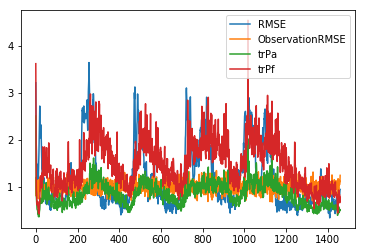

1.1460990284752994


In [72]:
t = 1460
N = 40
m = 10
h = 0.01 
F = 8.0


dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
B = []
A_=[]
for i in range(20):
    a = i 
    for j in range(10):
        sigma=1.0+0.5*j
        #初期値
        Xa = np.zeros((N,m))
        Xc = np.random.rand(N,m)
        for j in range(500):
            Xb = Rungekutta4(Xc,h,F)
            Xc = Xb
        Xa = Xb
        mu = np.zeros(N-a)
        sigma2 = np.eye(N-a)
        EO = multivariate_normal(mu,sigma2,m).T
        #print(EO.shape)
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        A=[]
        A.append(1.0)
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            y = np.delete(Y[k],loc)
            DB=np.zeros((N,N))
            DK=np.zeros((N,N-a))
            LB=np.zeros((N,N))
            LK=np.zeros((N,N-a))
            obs=np.arange(N)
            obs = np.delete(obs,loc)
            for s in range(N):
                for u in range(N):
                    DB[s,u] = min(abs(s-u),N-abs(s-u))
            for s in range(N):
                for u in range(N-a):
                    DK[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
            d0 = 2*np.sqrt(10/3)*sigma
            r0 = np.exp(-d0**2/(2*sigma**2))
            LB = np.exp(-DB**2/(2*sigma**2))
            LK = np.exp(-DK**2/(2*sigma**2))
            LB[LB<r0] = 0
            LK[LK<r0] = 0
  
            (Xf,Pf,dXf,Xf_,alpha) = Forecast(Xa,y,m,a,A[-1],LB)
            #(Xf,Pf,dXf,Xf_,alpha) = Forecast(Xa,y,m,a,b,L)
            (Xa,Xa_,Pa) = Analysis(Xf,Pf,dXf,Xf_,y,EO,m,a,loc,LK)
            A.append(alpha)
            #print(alpha)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2,axis=1)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2,axis=1)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
        
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        alpha_=np.sum(np.array(A[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A_.append(alpha_)
        print(sigma,alpha_)
#print(trPa)
#print(R)
#KF = np.ones(np.array(B).size)*0.221851
#plt.plot(B,RMSE,label="RMSE")
#plt.plot(B,TrPa,label="trPa")
#plt.plot(B,TrPf,label="trPf")
#plt.plot(B,KF,label="KF")
#plt.xlabel("sigma")
#plt.title("PO,m=10")
#plt.legend()
#plt.savefig("POm=40.jpg")
#plt.show()

#plt.plot(B,A_)
#plt.title("PO,adaptive inflation")
#plt.xlabel("sigma")
#plt.savefig("POm=40alpha.jpg")
#plt.show()

plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("PO.jpg")
plt.show()
print(np.mean(R_[500:]))
df = pd.DataFrame(RMSE)
df.to_csv("PO-K.csv")

(200, 2)


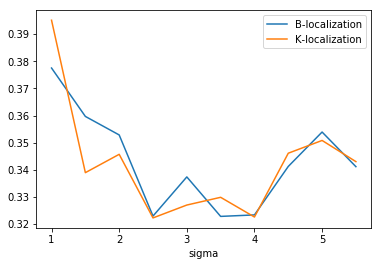

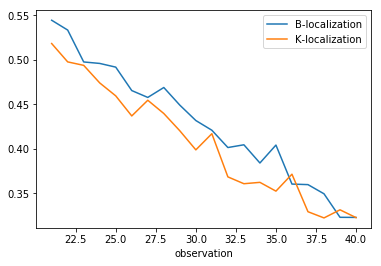

In [74]:
df=pd.read_csv("PO-B.csv")
df2=pd.read_csv("PO-K.csv")
rmse=df.values
rmse2=df2.values
print(rmse.shape)
R = rmse[:,1].reshape(20,10)
R2 = rmse2[:,1].reshape(20,10)
#print(R)
#print(R2)
y = [40-i for i in range(20)]
x = [1.0+0.5*j for j in range(10)]
Rsigma=[min(R[:,i]) for i in range(10)]
Rsigma2=[min(R2[:,i]) for i in range(10)]
plt.plot(x,Rsigma,label="B-localization")
plt.plot(x,Rsigma2,label="K-localization")
plt.xlabel("sigma")
plt.legend()
plt.show()
Rbeta = [min(R[i,:]) for i in range(20)]
Rbeta2 = [min(R2[i,:]) for i in range(20)]
plt.plot(y,Rbeta,label="B-localization")
plt.plot(y,Rbeta2,label="K-localization")
plt.xlabel("observation")
plt.legend()
plt.show()

# ETKF

In [60]:
def L96(Xa,F):
   
    F_ = (np.roll(Xa, -1, axis=0) - np.roll(Xa, 2, axis=0)) * np.roll(Xa, 1, axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,y,m,a,A,L):
    h = 0.05 
    F = 8.0
    b = 0.01
    
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    Pf = dXf @ dXf.T/(m-1)
    
    #d = np.zeros((p,m))
    #for k in range(m):
    #    d[:,k] = y - H @ Xf[:,k]
    #d_ = np.sum(d,axis=1)/m
    #do = [d[:,k]-d_ for k in range(m)]
    #dob = np.array(do).reshape(m,p).T
    #B = dob @ dob.T/(m-1)
    
    d = y - H @ Xf_
    do = d.reshape(-1,1)
    trPf = np.sum(np.diag(H @ Pf @ H.T))
    trB = np.sum(np.diag(do @ do.T))
    trR = np.sum(np.diag(R))
    
    alpha_ = (trB-trR)/trPf
    #print(alpha_)
    alpha = b*alpha_+(1-b)*A
    dXf = dXf*np.sqrt(alpha)
    Pf = Pf*alpha
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_,alpha

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,loc,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    dY = H @ dXf
    
    #カルマンゲインの導出
    A = H @ Pf @ H.T + R
    A_inv = np.linalg.inv(A)
    K = Pf @ H.T @ A_inv
    #K = L*K
    #print("K",K)
    
    
    #カルマンゲインの導出
    #A = dY @ dY.T + (m-1)*R
    #A_inv = np.linalg.inv(A)
    #K = dXf @ dY.T @ A_inv
    #K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    #K = L*K
    
    Xa_ = Xf_ + K @ (y - H @ Xf_)
    #print(Xa_)
    E = np.eye(m)
    TT = np.linalg.inv(E + dY.T @ np.linalg.inv(R) @ dY/(m-1))
    #print("TT",TT)
    
    la,v = np.linalg.eigh(TT)
    #print(v)
    D = np.diag(np.sqrt(la))
    #print(D)
    U = np.array(v).reshape(m,m)
    Q,R_=np.linalg.qr(U)
    
    T = Q @ D
    #print(T @ T.T)
    dXa = dXf @ T
    Xa = np.zeros((N,m))
    Xa = dXa + Xa_.reshape(-1,1)
    
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_



In [61]:
t = 1460
N = 40
m = 10
h = 0.01 
F = 8.0


dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
S = []
A_=[]
for i in range(20):
    a = i
    for j in range(1):
        sigma = 1.0+0.5*j
        #初期値
        Xa = np.zeros((N,m))
        Xc = np.random.rand(N,m)
        for j in range(200):
            Xb = Rungekutta4(Xc,h,F)
            Xc = Xb
        Xa = Xb
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        A=[]
        A.append(1.0)
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            DB=np.zeros((N,N))
            DK=np.zeros((N,N-a))
            LB=np.zeros((N,N))
            LK=np.zeros((N,N-a))
            obs=np.arange(N)
            obs = np.delete(obs,loc)
            for s in range(N):
                for u in range(N):
                    DB[s,u] = min(abs(s-u),N-abs(s-u))
            for s in range(N):
                for u in range(N-a):
                    DK[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
            d0 = 2*np.sqrt(10/3)*sigma
            r0 = np.exp(-d0**2/(2*sigma**2))
            LB = np.exp(-DB**2/(2*sigma**2))
            LK = np.exp(-DK**2/(2*sigma**2))
            LB[LB<r0] = 0
            LK[LK<r0] = 0
            #print(L)
            (Xf,Pf,dXf,Xf_,alpha) = Forecast(Xa,y,m,a,A[-1],LB)
            #print("Xf",Xf)
            (Xa,Pa,Xa_) = Analysis(Xf,Pf,dXf,Xf_,y,m,a,loc,LK)
            A.append(alpha)
            #print("Xa",Xa)
        
            if(k>500):
                rmse=np.zeros(m)
                rmsef = np.zeros(m)
                rmse_=0
                X1 = Xt[k,:]
                Y1 = Y[k,:]
                rmse = np.sum((Xa-X1.reshape(-1,1))**2,axis=1)
                rmsef = np.sum((Xf-X1.reshape(-1,1))**2,axis=1)
                rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
                rmseo = np.sum((Y1-X1)*(Y1-X1))
                rmse = np.sqrt(rmse/N)
                rmsef = np.sqrt(rmsef/N)
                rmse_ = np.sqrt(rmse_/N)
                rmseo = np.sqrt(rmseo/N)
                err = 0
                err2 = 0
                err = np.sqrt(np.sum(np.diag(Pa))/N)
                err2 = np.sqrt(np.sum(np.diag(Pf))/N)
                trPa.append(abs(err))
                trPf.append(abs(err2))
                R.append(rmse)
                Rf.append(rmsef)
                R_.append(rmse_)
                RO.append(rmseo)
                #if(k%100==0):
                 #   print(k)
        rb = np.sum(np.array(R_))/(t-500)
        trPab = np.sum(np.array(trPa))/(t-500)
        trPfb = np.sum(np.array(trPf))/(t-500)
        alpha_=np.sum(np.array(A))/(t)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A_.append(alpha_)
        S.append(sigma)
        print(a,sigma,alpha_)
    #print(trPa)
    #print(R_)
#KF = np.ones(np.array(S).size)*0.221851
#plt.plot(S,RMSE,label="RMSE")
#plt.plot(S,TrPa,label="trPa")
#plt.plot(S,TrPf,label="trPf")
#plt.plot(S,KF,label="KF")
#plt.xlabel("sigma")
#plt.title("ETKF,m=10")
#plt.show()
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("ETKFm=10.jpg")
plt.show()
#plt.plot(S,A_)
#plt.title("adaptive inflation")
#plt.savefig("ETKFalpham=10")
#plt.show()
df = pd.DataFrame(RMSE)
df.to_csv("ETKF-no.csv")

0 1.0 60.576971481755265
1 1.0 47.817776684737964
2 1.0 60.01284063396322
3 1.0 55.341959415844606
4 1.0 55.681221752138434
5 1.0 62.96920991426136
6 1.0 59.36007697290658


C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in sqrt


LinAlgError: Eigenvalues did not converge

(200, 2)


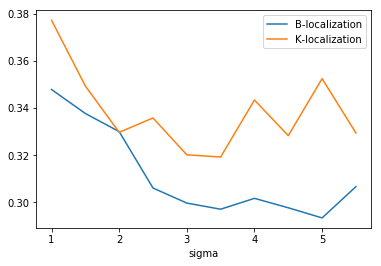

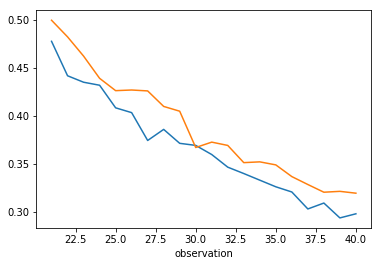

In [70]:
df=pd.read_csv("ETKF-B.csv")
df2=pd.read_csv("ETKF-K.csv")
rmse=df.values
rmse2=df2.values
print(rmse.shape)
R = rmse[:,1].reshape(20,10)
R2 = rmse2[:,1].reshape(20,10)
#print(R)
y = [40-i for i in range(20)]
x = [1.0+0.5*j for j in range(10)]
Rsigma=[min(R[:,i]) for i in range(10)]
Rsigma2=[min(R2[:,i]) for i in range(10)]
plt.plot(x,Rsigma,label="B-localization")
plt.plot(x,Rsigma2,label="K-localization")
plt.xlabel("sigma")
plt.legend()
plt.show()
Rbeta = [min(R[i,:]) for i in range(20)]
Rbeta2 = [min(R2[i,:]) for i in range(20)]
plt.plot(y,Rbeta,label="B-localization")
plt.plot(y,Rbeta2,label="K-localization")
plt.xlabel("observation")
plt.show()

# EnSRF

In [79]:
def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,y,m,a,A):
    h = 0.05 
    F = 8.0
    b = 0.01
    
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    #dXf = dXf*1.02
    Pf = dXf @ dXf.T/(m-1)
    
    #d = np.zeros((p,m))
    #for k in range(m):
    #    d[:,k] = y - H @ Xf[:,k]
    #d_ = np.sum(d,axis=1)/m
    #do = [d[:,k]-d_ for k in range(m)]
    #dob = np.array(do).reshape(m,p).T
    #B = dob @ dob.T/(m-1)
    
    d = y - H @ Xf_
    do = d.reshape(-1,1)
    trPf = np.sum(np.diag(H @ Pf @ H.T))
    trB = np.sum(np.diag(do @ do.T))
    trR = np.sum(np.diag(R))
    
    alpha_ = (trB-trR)/trPf
    #print(alpha_)
    alpha = b*alpha_+(1-b)*A
    dXf = dXf*np.sqrt(alpha)
    Pf = Pf * alpha
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_,alpha

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,loc,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    P0 = Pf
    dX0 = dXf
    X0_ = Xf_
    for i in range(p):
        H_ = np.reshape(H[i],(1,-1))
        #V1 = (H_ @ Z0).T
        D1 = H_ @ P0 @ H_.T+R[i,i]
        #print(D1)
        K1 = P0 @ H_.T @ np.linalg.inv(D1)
        K1_ = K1/(1+np.sqrt(R[i,i]/D1))
        K1_ = K1_.reshape(-1,1)*L[:,i].reshape(-1,1)
        Xa_ = X0_+K1 @ (y[i]-H_@X0_) 
        dXa = (I - K1_ @ H_) @ dX0
        Pa = dXa@dXa.T/(m-1)
        #Pa = Pa*L
        
        X0_ = Xa_
        dX0 = dXa
        P0 = Pa
        
    Xa = np.zeros((N,m))
    Xa = dXa + Xa_.reshape(-1,1)
    
    
    return Xa,Pa,Xa_



0 1.0 1.1042936689815528
0 1.5 1.1131440697710024
0 2.0 1.1249077912112873
0 2.5 1.1410227032865592


C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in sqrt
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in sqrt


0 3.0 nan
0 3.5 nan
0 4.0 1.1798964068921916
0 4.5 1.187168873472973
0 5.0 1.1694088300286987
0 5.5 nan
1 1.0 1.1059105221255838
1 1.5 1.1073063173924174
1 2.0 1.1181920992200538
1 2.5 1.152240237787716
1 3.0 nan
1 3.5 1.1434714621988604
1 4.0 nan
1 4.5 nan
1 5.0 nan
1 5.5 1.1699795671686324
2 1.0 1.1055743892955223
2 1.5 1.0965861054323411
2 2.0 1.1145298322789456
2 2.5 nan
2 3.0 nan
2 3.5 1.1640785605019015
2 4.0 nan
2 4.5 1.2870209723282897
2 5.0 1.5766694394137593
2 5.5 nan
3 1.0 1.1110011227943735
3 1.5 1.1347435143923652
3 2.0 1.1523084565669965
3 2.5 1.1247285176476682
3 3.0 nan
3 3.5 1.142903525901109
3 4.0 1.2891032656310686
3 4.5 1.1884611159327132
3 5.0 1.2194291909752515
3 5.5 nan
4 1.0 1.1048985825998647
4 1.5 1.101273028644589
4 2.0 1.109823411346285
4 2.5 nan
4 3.0 1.1403451028092846
4 3.5 1.1606848070034137
4 4.0 nan
4 4.5 1.1927596959400684
4 5.0 1.151169663202907
4 5.5 1.223393275607502
5 1.0 1.0948251709850154
5 1.5 1.0951012561883269
5 2.0 1.1017988639210994
5 2.5 1

C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in add
C:\Users\saori\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in subtract
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in square


13 2.5 nan
13 3.0 1.0955199927435724
13 3.5 1.152816935664388
13 4.0 1.1402405863095904
13 4.5 1.1630208083738274
13 5.0 1.1754053717674386
13 5.5 1.3443242330089922
14 1.0 1.0732033061057602
14 1.5 1.0865279914100512
14 2.0 1.0956693136883657
14 2.5 1.092118551170174
14 3.0 nan
14 3.5 1.0991579513312568
14 4.0 1.1222994175190442
14 4.5 2.6775668510230894
14 5.0 1.1178858012441073
14 5.5 nan
15 1.0 1.0894806101555985
15 1.5 1.0999183828438848
15 2.0 1.094962634161083
15 2.5 1.0911148974175269
15 3.0 1.1510519938008454
15 3.5 1.483000252729512
15 4.0 nan
15 4.5 1.1079488634880243
15 5.0 1.148052678398525
15 5.5 nan
16 1.0 1.0840074860871864
16 1.5 1.0753524235606993
16 2.0 1.1150948353637204
16 2.5 1.1126308703965881
16 3.0 1.0871057790289518
16 3.5 nan
16 4.0 1.2116879440798456
16 4.5 nan
16 5.0 1.3240776332483635
16 5.5 1.1726981483554892
17 1.0 1.0886068790184706
17 1.5 1.0961801751544005
17 2.0 1.0778188907751727
17 2.5 1.1023493718255544
17 3.0 1.1694932824776172
17 3.5 1.160644443

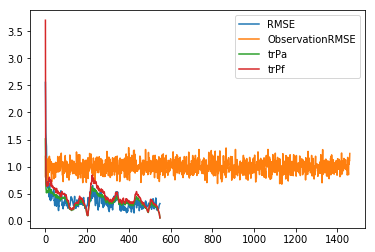

In [82]:
t = 1460
N = 40
m = 10
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A_ = []
B = []
for i in range(20):
    a = i
    for j in range(10):
        sigma = 1.0+0.5*j
        #初期値
        Xa = np.zeros((N,m))
        Xc = np.random.rand(N,m)
        for j in range(500):
            Xb = Rungekutta4(Xc,h,F)
            Xc = Xb
        Xa = Xb
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        A = []
        A.append(1.0)
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            DB=np.zeros((N,N))
            DK=np.zeros((N,N-a))
            LB=np.zeros((N,N))
            LK=np.zeros((N,N-a))
            obs=np.arange(N)
            obs = np.delete(obs,loc)
            for s in range(N):
                for u in range(N):
                    DB[s,u] = min(abs(s-u),N-abs(s-u))
            for s in range(N):
                for u in range(N-a):
                    DK[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
            d0 = 2*np.sqrt(10/3)*sigma
            #r0 = np.exp(-d0**2/(2*sigma**2))
            LB = np.exp(-DB**2/(2*sigma**2))
            LK = np.exp(-DK**2/(2*sigma**2))
            LB[DB>d0] = 0
            LK[DK>d0] = 0            
            
            (Xf,Pf,dXf,Xf_,alpha) = Forecast(Xa,y,m,a,A[-1])
            (Xa,Pa,Xa_) = Analysis(Xf,Pf,dXf,Xf_,y,m,a,loc,LB)
            #print(Xf)
            A.append(alpha)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k]
            Y1 = Y[k]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2,axis=1)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2,axis=1)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        alpha_ = np.sum(np.array(A[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A_.append(alpha_)
        B.append(sigma)
        print(a,sigma,alpha_)
#print(trPa)
#print(R)
#plt.plot(B,RMSE,label="RMSE")
#plt.plot(B,TrPa,label="trPa")
#plt.plot(B,TrPf,label="trPf")
#plt.xlabel("observation missing")
#plt.title("EnSRF,m=10")
#plt.legend()
#plt.show()
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()
df=pd.DataFrame(RMSE)
df.to_csv("EnSRF-K.csv")

(200, 2)


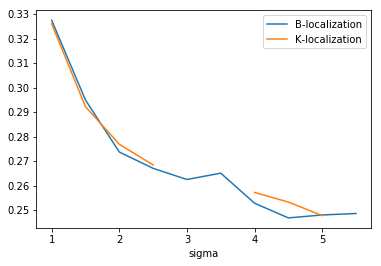

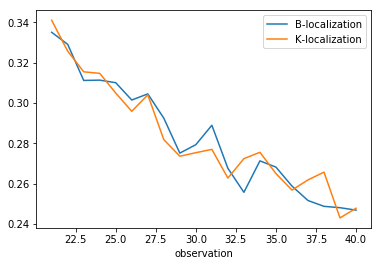

In [84]:
df=pd.read_csv("EnSRF-B.csv")
df2=pd.read_csv("EnSRF-K.csv")
rmse=df.values
rmse2=df2.values
print(rmse.shape)
R = rmse[:,1].reshape(20,10)
R2 = rmse2[:,1].reshape(20,10)
#print(R)
y = [40-i for i in range(20)]
x = [1.0+0.5*j for j in range(10)]
Rsigma=[min(R[:,i]) for i in range(10)]
Rsigma2=[min(R2[:,i]) for i in range(10)]
plt.plot(x,Rsigma,label="B-localization")
plt.plot(x,Rsigma2,label="K-localization")
plt.xlabel("sigma")
plt.legend()
plt.show()
Rbeta = [min(R[i,:]) for i in range(20)]
Rbeta2 = [min(R2[i,:]) for i in range(20)]
plt.plot(y,Rbeta,label="B-localization")
plt.plot(y,Rbeta2,label="K-localization")
plt.xlabel("observation")
plt.legend()
plt.show()

(200, 2)
(200, 2)
(840, 3)


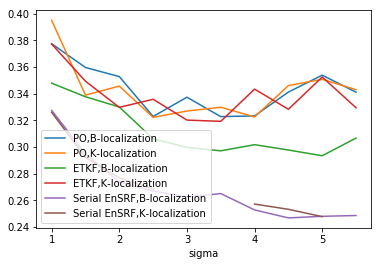

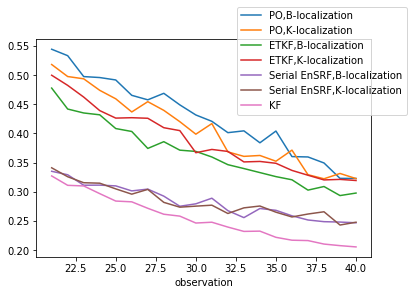

In [45]:
###### df=pd.read_csv("PO-B.csv")
df2=pd.read_csv("PO-K.csv")
rmse=df.values
rmse2=df2.values
print(rmse.shape)
RP = rmse[:,1].reshape(20,10)
RP2 = rmse2[:,1].reshape(20,10)
#print(RP)

df3=pd.read_csv("ETKF-B.csv")
df4=pd.read_csv("ETKF-K.csv")
rmse3=df3.values
rmse4=df4.values
print(rmse.shape)
RT = rmse3[:,1].reshape(20,10)
RT2 = rmse4[:,1].reshape(20,10)

df5=pd.read_csv("EnSRF-B.csv")
df6=pd.read_csv("EnSRF-K.csv")
rmse5=df5.values
rmse6=df6.values
#print(rmse.shape)
RS = rmse5[:,1].reshape(20,10)
RS2 = rmse6[:,1].reshape(20,10)
#print(R)

dfKF=pd.read_csv("KF.csv")
rmseKF=dfKF.values
print(rmseKF.shape)
RKF=rmseKF[:,2].reshape(21,-1)
#print(RKF)
y = [40-i for i in range(20)]
x = [1.0+0.5*j for j in range(10)]

dfL = pd.read_csv("LETKF.csv")
rmseL = dfL.values
RL = rmseL[:,1].reshape(20,1)

RPsigma=[min(RP[:,i]) for i in range(10)]
RPsigma2=[min(RP2[:,i]) for i in range(10)]
RTsigma=[min(RT[:,i]) for i in range(10)]
RTsigma2=[min(RT2[:,i]) for i in range(10)]
RSsigma=[min(RS[:,i]) for i in range(10)]
RSsigma2=[min(RS2[:,i]) for i in range(10)]

plt.plot(x,RPsigma,label="PO,B-localization")
plt.plot(x,RPsigma2,label="PO,K-localization")
plt.plot(x,RTsigma,label="ETKF,B-localization")
plt.plot(x,RTsigma2,label="ETKF,K-localization")
plt.plot(x,RSsigma,label="Serial EnSRF,B-localization")
plt.plot(x,RSsigma2,label="Serial EnSRF,K-localization")
plt.xlabel("sigma")
plt.legend()
plt.show()

RPbeta = [min(RP[i,:]) for i in range(20)]
RPbeta2 = [min(RP2[i,:]) for i in range(20)]
RTbeta = [min(RT[i,:]) for i in range(20)]
RTbeta2 = [min(RT2[i,:]) for i in range(20)]
RSbeta = [min(RS[i,:]) for i in range(20)]
RSbeta2 = [min(RS2[i,:]) for i in range(20)]
RKFbeta=[min(RKF[i,:]) for i in range(20)]
RLbeta=[min(RL[i,:]) for i in range(20)]

plt.plot(y,RPbeta,label="PO,B-localization")
plt.plot(y,RPbeta2,label="PO,K-localization")
plt.plot(y,RTbeta,label="ETKF,B-localization")
plt.plot(y,RTbeta2,label="ETKF,K-localization")
plt.plot(y,RSbeta,label="Serial EnSRF,B-localization")
plt.plot(y,RSbeta2,label="Serial EnSRF,K-localization")
#plt.plot(y,RLbeta,label="LETKF,R-localization")
plt.plot(y,RKFbeta,label="KF")
plt.xlabel("observation")
plt.legend(bbox_to_anchor=(0.6,1.15), loc='upper left',borderaxespad=0)
plt.savefig("localization")
plt.show()

# LETKF

In [9]:
def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,y,m,a,A):
    h = 0.05 
    F = 8.0
    b = 0.01
    
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    Pf = dXf @ dXf.T/(m-1)
    """
    #d = np.zeros((p,m))
    #for k in range(m):
    #    d[:,k] = y - H @ Xf[:,k]
    #d_ = np.sum(d,axis=1)/m
    #do = [d[:,k]-d_ for k in range(m)]
    #dob = np.array(do).reshape(m,p).T
    #B = dob @ dob.T/(m-1)
    
    d = y - H @ Xf_
    do = d.reshape(-1,1)
    trPf = np.sum(np.diag(H @ Pf @ H.T))
    trB = np.sum(np.diag(do @ do.T))
    trR = np.sum(np.diag(R))
    
    alpha_ = (trB-trR)/trPf
    #print(alpha_)
    alpha = b*alpha_+(1-b)*A
    dXf = dXf*np.sqrt(alpha)
    Pf = Pf*alpha
    """
    return Xf,Pf,dXf,Xf_

def Analysis(dXf,Xf_,y,m,a,loc,rho,sigma):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(m)

    obs=np.arange(N)
    obs=np.delete(obs,loc)
    D = np.zeros((N,p))
    for s in range(N):
        for u in range(p):
            D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
    #print(obs)
    Xa = np.zeros((N,m))
    Xa_ = np.zeros(N)
    dXa = np.zeros((N,m))
    #使う値は前後10点に限定
    for i in range(N):
        d = D[i]
        far = np.arange(p)
        far = far[d>2*np.sqrt(10/3)*sigma]
        yi = y
        Hi = H
        Ri = R
        yi = np.delete(yi,far)
        Hi = np.delete(Hi,far,axis=0)
        Ri = np.delete(Ri,far,axis=0)
        Ri = np.delete(Ri,far,axis=1)
        #print(yi.shape,Hi.shape,Ri.shape)
        diagR = np.diag(Ri)
        di = yi - Hi @ Xf_
        dYi = Hi @ dXf
        L = np.exp(-d**2/(2*sigma**2))
        L = np.delete(L,far)
        Ri = np.diag(diagR/L)
        R_inv = np.linalg.inv(Ri)
    
        A = (m-1)*I/rho + dYi.T @ R_inv @ dYi
        la,v = np.linalg.eigh(A) #eigenvalue decomposition
        D_inv = np.linalg.inv(np.diag(la))
        U = np.array(v).reshape(m,m)
        Pa_ = U @ D_inv @ U.T #UD^(-1)UT
        #print(Pa_)
    
        Xa_[i] = Xf_[i] + dXf[i,:] @ Pa_ @ dYi.T @ R_inv @ di 
        Pa_root = U @ np.sqrt(D_inv) @ U.T
        Pa_root = Pa_root * np.sqrt(m-1)
        dXa[i,:] = dXf[i,:] @ Pa_root
        Xa[i,:] = np.full(m,Xa_[i]) + dXa[i,:]
            
    #print("Xa_",Xa_)
    #print("dXa",dXa)
    #print("Xa",Xa)
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_

0 5.0
1 5.0
2 5.0
3 5.0
4 5.0
5 5.0
6 5.0
7 5.0
8 5.0
9 5.0
10 5.0
11 5.0
12 5.0
13 5.0
14 5.0
15 5.0
16 5.0
17 5.0
18 5.0
19 5.0


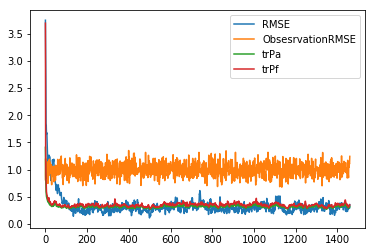

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.29860457615180097


In [25]:
t = 1460
N = 40
m = 10
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A_ = []
B = []
for i in range(20):
    a = i
    for j in range(1):
        rho = 1.06
        sigma = 5.0
        #初期値
        Xa = np.zeros((N,m))
        Xc = np.random.rand(N,m)
        for j in range(500):
            Xb = Rungekutta4(Xc,h,F)
            Xc = Xb
        Xa = Xb
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        A = []
        A.append(1.0)
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,y,m,a,A[-1])
            (Xa,Pa,Xa_) = Analysis(dXf,Xf_,y,m,a,loc,rho,sigma)
            #print(Xf)
            A#.append(alpha)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2,axis=1)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2,axis=1)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        alpha_ = np.sum(np.array(A[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A_.append(alpha_)
        B.append(sigma)
        print(a,sigma)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObsesrvationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()
print(A_)
print(np.mean(R_[500:]))
df = pd.DataFrame(RMSE)
df.to_csv("LETKF.csv")

No handles with labels found to put in legend.


(20, 2)


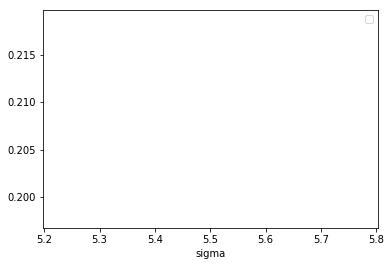

No handles with labels found to put in legend.


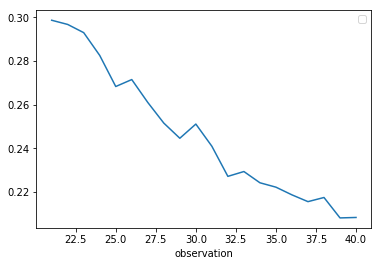

In [26]:
df=pd.read_csv("LETKF.csv")
rmse=df.values
print(rmse.shape)
R = rmse[:,1].reshape(20,1)
#print(R)
y = [40-i for i in range(20)]
x = [5.5+0.5*j for j in range(1)]
Rsigma=[min(R[:,i]) for i in range(1)]
plt.plot(x,Rsigma)
plt.xlabel("sigma")
plt.legend()
plt.show()
Rbeta = [min(R[i,:]) for i in range(20)]
plt.plot(y,Rbeta)
plt.xlabel("observation")
plt.legend()
plt.show()